In [1]:
from transformers import GPT2Tokenizer, GPT2Model
from datasets import load_dataset

import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt
from model import CausalModel

In [2]:
gpt2 = GPT2Model.from_pretrained("gpt2")

class TinyShakespeareDataset(Dataset):
    def __init__(self):
        output_embeddings_file = 'embeddings.pt' 
        data = torch.load(output_embeddings_file)

        self.embeddings = data['embeddings']
        self.targets = data['targets']

    def __len__(self):
        return self.embeddings.shape[0]
    
    def __getitem__(self, idx):
        return self.embeddings[idx,:,:], self.targets[idx,:]

In [3]:
dataset = TinyShakespeareDataset()
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

# Split the dataset into training and testing sets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

C:\Users\bicke\AppData\Local\Temp\ipykernel_20932\1972066637.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(output_embeddings_file)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


vocab_size = 50257  # GPT-2 tokenizer vocabulary size
d_embed = 768  # Embedding dimension
epochs = 3
max_sequence_length = 1000
chunk_size = 50  # New sequence chunk size

# Example Causal Model (you should have this already defined)
model = CausalModel(vocab_size, max_sequence_length=chunk_size, num_layers=3).to(device)
model.train()

optim = torch.optim.Adam(params=model.parameters(), lr=0.0003)
loss_fn = F.cross_entropy

# Assume your train_loader provides input tensors of shape [batch_size, 1000, d_embed]
loss_over_time = []

for epoch in range(epochs):
    for idx, (embeddings, labels) in enumerate(train_loader):
        batch_size, sequence_length, d_embed = embeddings.shape

        # Break each 1000-token sequence into chunks of 50 tokens
        num_chunks = sequence_length // chunk_size
        embeddings = embeddings[:, :num_chunks * chunk_size, :].reshape(batch_size * num_chunks, chunk_size, d_embed).to(device)
        labels = labels[:, :num_chunks * chunk_size].reshape(batch_size * num_chunks, chunk_size).to(device)

        # Create padding mask (no padding here, but adding for future flexibility)
        padding_mask = (torch.zeros(batch_size * num_chunks, chunk_size) == 1).to(device)

        # Forward pass through the model
        logits = model(embeddings, padding_mask)

        # Compute loss
        loss = loss_fn(logits.permute(0, 2, 1), labels)

        loss_over_time.append(loss.item())

        optim.zero_grad()
        loss.backward()
        optim.step()

        print(f"Loss at batch {idx}: {loss.item()}")



NameError: name 'CausalModel' is not defined

In [8]:
for embeddings, labels in test_loader:
    test_label = labels
    break

In [15]:

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
test_label[0].shape

c:\Users\bicke\anaconda3\envs\megatron\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


torch.Size([1000])

In [61]:
n = 10  # Number of tokens you want to generate
sequence = test_label[0][40:55]  # Starting sequence (first 20 tokens)

print("Initial sequence:", tokenizer.decode(sequence))

for _ in range(n):
    # Get embeddings for the current sequence
    embeddings = gpt2(sequence)[0]  # Get hidden state (embeddings) from GPT-2
    
    # Pad the embeddings to a fixed size of 1000
    padding = torch.zeros(50 - embeddings.shape[0], embeddings.shape[1])
    embeddings = torch.cat((embeddings, padding), dim=0)
    
    # Create padding mask (0 for actual tokens, 1 for padding)
    padding_mask = torch.ones(50)
    padding_mask[0:len(sequence)] = 0
    
    # Pass through the model
    logits = model(embeddings, padding_mask)
    
    # Get the next token (greedy, selecting the token with the highest logit at the current position)
    next_token = logits[len(sequence)].argmax().item()
    
    # Append the next token to the sequence
    sequence = torch.cat((sequence, torch.tensor([next_token])), dim=0)
    
    # Decode and print the current sequence
    print(f"Next token: {tokenizer.decode([next_token])} with confidence {logits[len(sequence)].max().item()}")
    print(f"Current sequence: {tokenizer.decode(sequence)}")


Initial sequence:  kick'd at,
And look'd upon things precious as they were

Next token: : with confidence 10.269601821899414
Current sequence:  kick'd at,
And look'd upon things precious as they were
:
Next token: : with confidence 9.32603931427002
Current sequence:  kick'd at,
And look'd upon things precious as they were
::
Next token: : with confidence 9.908794403076172
Current sequence:  kick'd at,
And look'd upon things precious as they were
:::
Next token: : with confidence 10.220682144165039
Current sequence:  kick'd at,
And look'd upon things precious as they were
::::
Next token: : with confidence 10.351892471313477
Current sequence:  kick'd at,
And look'd upon things precious as they were
:::::
Next token: : with confidence 10.082300186157227
Current sequence:  kick'd at,
And look'd upon things precious as they were
::::::
Next token: : with confidence 9.756336212158203
Current sequence:  kick'd at,
And look'd upon things precious as they were
:::::::
Next token: : with confid

In [59]:
import torch

# Save only the model's state dictionary (recommended way)
torch.save(model.state_dict(), 'better_three_layers_three_epochs_model_state.pth')


In [63]:
tokenizer.decode(logits[len(sequence)].sort(descending=True).indices)

':,ius ofU\'d.;ENam?io Citizen!sciusousb-rahantbromaningy\'sar SenatorIC\'UCAMlyUCKanusleOLinaINge LAings thanIO MurdedKEio.\'USow toesINCom Viorationin andUE VIAD\nestostONTuke,\'IAORKishfully Servererian MARICHOMUMaltureful CAP Servingheeer!\'fordalnesslessenia BULORDownent IVetityunesit IIiolomeceslanduldillokeurse LorduABhipbruletardlingufASTiansEL L ELorUTRAEOmenolerusensTERishmentIRistaETumberENTchCHenceARaudiorepe thereofES meock:\' lordrilyourageiesthads oethRIricilesonIONengerARDWARD OFifferscesterELL ED XIINAileORTorsableuneneloursagenenesbyATESterALidaryatress withatesatoreterRYINGablyIZULEminksAT CapESSa HwaiarscaoveICKardonenessARThenORled Mayoranend my atncetsisedgesLANDERierumBERiedardsryordsementIXwardpion on tooitizensftpherdiestster MarshalTH MosallYC isheikeANOUencygessVOLIFFEdOPceIDixt AN-- thatzoseateagueIGiciousience Aithere yearsionsruance home Richardakclauntlerowsie daysiousothinesswellCf beforellber moreentlyOWallyLEY ichesray youifulations GareasgedcherisonIS

In [62]:
logits[len(sequence)].sort(descending=True)

torch.return_types.sort(
values=tensor([ 8.8818,  7.6540,  6.8998,  ..., -5.7699, -5.7856, -5.8333],
       grad_fn=<SortBackward0>),
indices=tensor([   25,    11,  3754,  ..., 27843, 47946, 10090]))

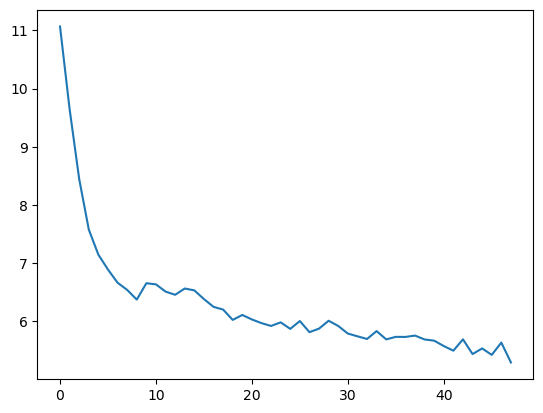

In [41]:
plt.plot([x.detach().numpy() for x in  loss_over_time])

In [29]:
embeddings.shape

torch.Size([20, 768])

torch.Size([20, 768])

In [ ]:
model(embeddings)

In [21]:
print(tokenizer.decode(test_label[0][0:65]))

US:
Worthy man!

First Senator:
He cannot but with measure fit the honours
Which we devise him.

COMINIUS:
Our spoils he kick'd at,
And look'd upon things precious as they were
The common muck of the world: he cove
